In [236]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy

## Part 1 ‑ Exploratory data analysis

The data is stored in a json file. We first extract the json string and then use json_normalize to output a DataFrame object  

In [237]:
with open('logins.json') as logins_file:
    logins_string = json.load(logins_file)
    logins_df = json_normalize(logins_string,'login_time')

Since the data is a time series type we convert the single column of the DataFrame to Datetime and set it as the DataFrame Index. Lastly we create a column of '1's which is used later for aggregating the data

In [238]:
logins_df = pd.to_datetime(logins_df.iloc[:,0]).to_frame()
logins_df = logins_df.rename(columns={0:"login_time"})
logins_df.set_index('login_time', inplace=True)
logins_df['logins_made'] = 1

In [239]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
logins_made    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


The above shows that the data is from January 01, 1970 to April 13, 1970

In [240]:
logins_df = logins_df.groupby(pd.Grouper(freq='15min')).aggregate(numpy.sum)

In [241]:
logins_df.mean()

logins_made    9.515938
dtype: float64

During the entire period on average there are 9.5 logins in a 15 mninute interval

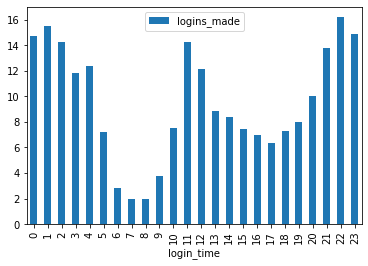

In [242]:
logins_df.groupby(logins_df.index.hour).mean().plot(kind='bar')

On average during the entire period from 01/01/1970 to 04/13/1970 their is a sharp decline in user logins between the times 6:00 am to 9:00 am. This may indicate an issue that merits further investigation or maybe this is generally a low demand period.
9:00 pm to 4:00 am are peak hours. In addition there is a peak at 11:00 am and 12 noon (lunch time?).

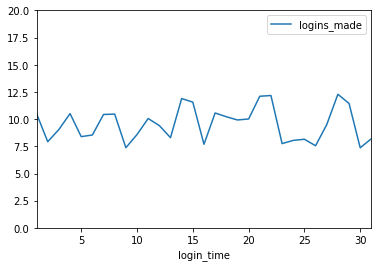

In [243]:
logins_df.groupby(logins_df.index.day).mean().plot(ylim=(0,20))

Looking at average 15 minute interval logins each day during the course of each month does not reveal any anomolies and shows that in general there are approximately between 7.15 to 12.5 logins in a 15 minute internval. Now let's look at the overall behavior each day of the week during the entire time period from Jan 01, 1970 to April 13, 1970 

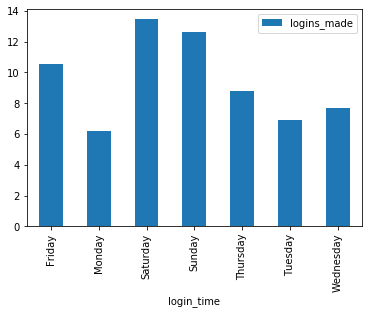

In [244]:
logins_df.groupby(logins_df.index.weekday_name).mean().plot(kind='bar')

Looks like there's more demand on the weekends and then Fridays.

In [245]:
friday = logins_df[logins_df.index.weekday_name == 'Friday']
saturday = logins_df[logins_df.index.weekday_name == 'Saturday']
sunday = logins_df[logins_df.index.weekday_name == 'Sunday']
weekday = logins_df[logins_df.index.dayofweek < 5]

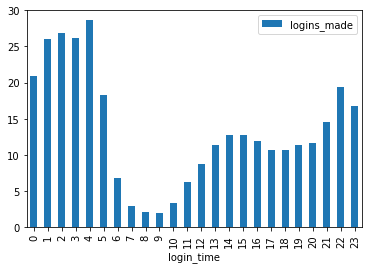

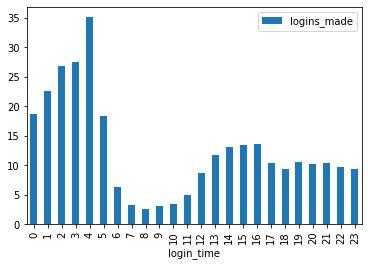

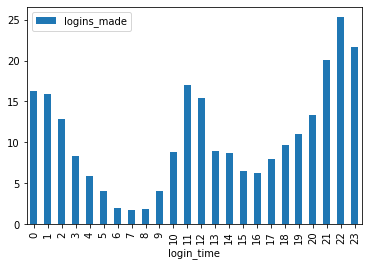

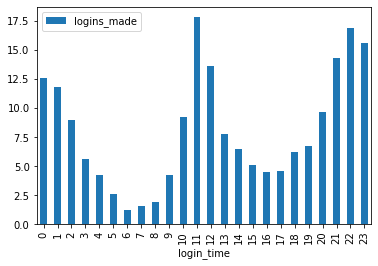

In [246]:
saturday.groupby(friday.index.hour).mean().plot(kind='bar')
sunday.groupby(friday.index.hour).mean().plot(kind='bar')
friday.groupby(friday.index.hour).mean().plot(kind='bar')
weekday.groupby(weekday.index.hour).mean().plot(kind='bar')

Demand patterns on the weekend is different from that during the weekday. Weekends are busy from midnight to 5:00 am with highest demand at 4:00 am. Sunday evening demand is much lesser than Saturday evening.

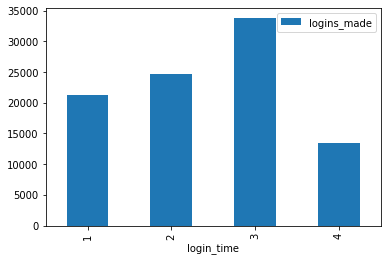

In [247]:
logins_df.groupby(logins_df.index.month).sum()[0:4].plot(kind='bar')

During Q1 (Jan-Mar) the total number of logins in a month have been steadily increasing. We only have data for almost half of April however even if we interpolate the numbers there is a dip from 34K logins to 27K (13.5K *2) logins from March to April. This root cause of this dip should be investigated.

,logins_made
0.01,0.0
0.25,3.0
0.50,7.0
0.75,13.0
0.99,38.0


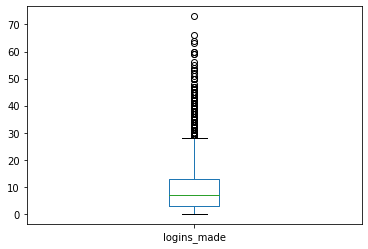

In [248]:
logins_df.plot(kind='box')
logins_df.quantile([0.01, 0.25, 0.5, 0.75, 0.99])

It would also merit to look at the 15 minute intervals where there were 38 or more logins made. See if anything special happened on those days ( e.g. promotion )

In [249]:
outliers = logins_df.loc[logins_df.index[logins_df['logins_made'] >= 38]]

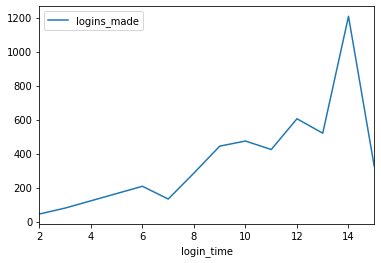

In [250]:
outliers.groupby(outliers.index.week).sum().plot()

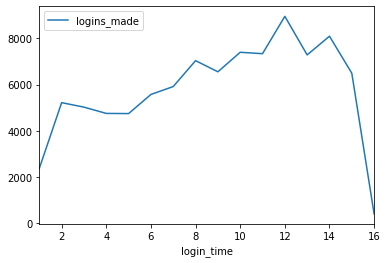

In [251]:
logins_df.groupby(logins_df.index.week).sum().plot()

Comparing the above two graphs show that on week 14 there was a sharp increase in the number logins made during a 15 minute interval compared to previous weeks whereas the overall number of logins made ( again in a 15 minute intervals) showed a relatively minor change during week 14 when compared to previous weeks.  

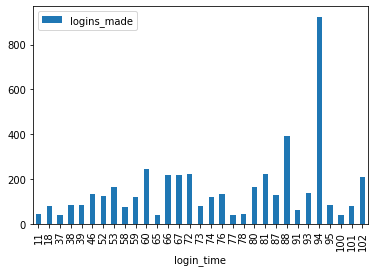

In [254]:
df = logins_df.loc[logins_df.index[logins_df.logins_made >= 38]].sort_index()
df.groupby(df.index.dayofyear).sum().plot(kind='bar')

On day 94 of the year (April 4) there was 924 15 minute intervals where 38 or more logins were made. Maybe we should check with marketing if any promotion was done during this day as this looks like a data anomoly. Day 88 should also be investigated further.

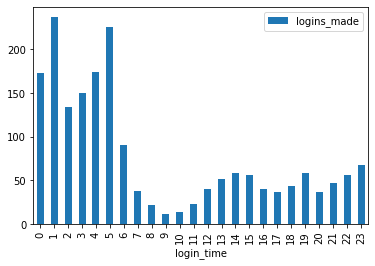

In [275]:
d94 = logins_df[logins_df.index.dayofyear == 94]
d94.groupby(d94.index.hour).sum().plot(kind='bar')